In [1]:
from bentPlumeAnalyser import *
from fumarolePlumeModel import *
from scipy.io.matlab import loadmat
from itertools import product

import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys
import json

# Set numpy options, notably for the printing of floating point numbers
np.set_printoptions(precision=6)

# Set matplotlib options
mpl.rcParams['figure.dpi'] = 300

In [2]:
def integrator(V0, p):
    # Initialise an integrator object
    r = ode(derivs).set_integrator('lsoda', nsteps=1e6)
    r.set_initial_value(V0, 0.)
    r.set_f_params(p)
    
    # Define state vector and axial distance
    V = []    # State vector
    s = []    # Axial distance
    V.append(V0)
    s.append(sexp[0])
    
    # Define the individual variables - these will be calculated at run time
    Q, M, F, theta = 0., 0., 0., 0.
    Q = np.float64(Q0)
    M = np.float64(M0)
    F = np.float64(F0)
    theta = np.float64(theta0)
    
    ####################################

    # Integrate, whilst successful, until the domain size is reached
    ind = 0
    while r.successful() and r.t < t1 and M >= 0.:
        dt = dsexp[ind]
        r.integrate(r.t + dt)
        V.append(r.y)
        s.append(r.t)
        Q, M, F, theta = r.y
        ind += 1
    s = np.array(s)
    V = np.float64(np.array(V))
    return s, V

In [3]:
exptNo      = 4
plotResults = True

# Read analysed experimental data from file
fname    = './data/ExpPlumes_for_Dai/GCTA_plumeData.xlsx'
# exptData = pandas.read_excel(fname, sheet_name='exp%02d' % exptNo)

# # Display the first 5 lines of the data frame
# exptData.head()

In [5]:
## DEFINE THE DISTANCE ALONG THE AXIS, THE ANGLE AND THE WIDTH OF THE PLUME
# sexp  = exptData.distAlongAxis
# thexp = exptData.plumeAngle
# bexp  = exptData.plumeWidth

path = './data/ExpPlumes_for_Dai/exp%02d/' % exptNo

skip = 10  # How many points to skip

xexp = loadmat(path + 'xcenter.mat')['xcenter'][0]
zexp = loadmat(path + 'zcenter.mat')['zcenter'][0]
Ox, Oz = (xexp[0], zexp[0])
pPixels = np.array([xexp, zexp]).T[::skip]

data, xexp, zexp, extent = loadExptData(exptNo)
if data.mean() < .5:
    data = 1. - data
p = np.array([xexp, zexp]).T[::skip]

# # # Uncomment if user guesses are to be used for the plume trajectory
# # with open(path + 'exp%02d_initGuess.json' % exptNo) as f:
# #     exptData = json.load(f)
# # p = np.array(exptData['data'])
# pPixels = p.copy() * scaleFactor
# pPixels[:,0] += Ox
# pPixels[:,1] -= Oz
# pPixels[:,1] *= -1

# Calculate angle, width and distance along plume and errors
thexp, sig_thexp = plumeAngle(p[:,0], p[:,1], errors=[1/scaleFactor]*2)
_, bexp, sig_p, sig_bexp = trueLocationWidth(pPixels, data, errors=[1/scaleFactor])
sexp      = distAlongPath(p[:,0], p[:,1])
bexp     /= scaleFactor
sig_bexp /= scaleFactor
bexp[0]   = 0.55 / 2
thexp[0]  = np.pi / 2

In [10]:
# Import table of experimental conditions
GCTA = pandas.read_excel('./data/ExpPlumes_for_Dai/TableA1.xlsx', sheet_name='CGSdata', skiprows=2, 
                         names=('exptNo', 'rhoa0', 'sig_rhoa0', 'N', 'sig_N', 'rho0', 'sig_rho0', 'U0', 'sig_U0', 'W', 'sig_W', 
                                'gp', 'sig_gp', 'Q0','sig_Q0', 'M0', 'sig_M0', 'F0', 'sig_F0', 'Ri_0', 'sig_Ri_o', 'W*','sig_W*'))

# Extract densities of ambient and plume, and calculate g' at the source
expt  = GCTA[GCTA['exptNo'] == 3]
rhoa0 = expt['rhoa0']
rho0  = expt['rho0']
g = 981 #cm/s²
gp0   = (rhoa0 - rho0) / rhoa0 * g

parameters = pandas.read_excel('./data/ExpPlumes_for_Dai/TableA1.xlsx', sheet_name='CGSparameters')
b0theoretical = parameters[parameters['property'] == 'nozzleSize']['value'].values[0]
u0theoretical = expt['U0'].values[0]

In [11]:
# Load initial conditions for a given experiment, run the model for those conditions 
# and then compare model and experimental data
# fig, ax = plt.subplots()
# ax.plot(exptData.plumeWidth, exptData.distAlongAxis, 'g.', label='natural')
V0, p = loadICsParameters(pathname, exptNo, alpha=0.05, beta=0, m=2)

#p = (0.05, .5, .012, 2., 4.)
nGrid = 51   # Number of grid points
b0Vec = np.linspace(.05, 2, nGrid) #cm
u0Vec = np.linspace(5, 30, nGrid) #cm/s
Q0Vec = u0Vec * b0Vec**2 #cm3/s
M0Vec = Q0Vec * u0Vec #cm4/s2

theta0 = np.pi / 2

objFn, initialConds = [], []
# Set integration domain and step size
t1    = sexp.max()    # Domain of integration
dsexp = np.diff(sexp) # Discretise the distance along plume axis - use as integration steps 

sequence = [Q0Vec, M0Vec]

for (Q0, M0) in list(product(*sequence)):
    F0 = Q0 * gp0
    V0 = [Q0, M0, F0, theta0]
    
    # Call the 'integrator' function (defined above) to solve
    # the model
    s, V = integrator(V0, p)
    Q, M, F, theta = [V[:,i] for i in range(4)]
    
    #######################################
    
    b  = Q / np.sqrt(M) / np.sqrt(2) # Factor of sqrt{2} to correspond with top-hat model
    u  = M / Q
    gp = F / Q
    
    Vexp = np.array([thexp]).ravel(order='C')
    Vsyn = np.array([theta]).ravel(order='C')
    sigV = np.array([sig_thexp]).ravel(order='C')
    CovV = np.diag(sigV**2)

    objFn.append(objectiveFn(Vexp, Vsyn, cov=CovV, p=p))
    initialConds.append(V0)
#     ax.plot(b, s, '-', label='Model %.4f %.4f %.4f' % (Q0, M0, F0))
    
#ax.legend(loc=5)
# ax.set_xlim((0, 25))

# Transform initialConds and objFn from lists to arrays, 
# reshaping the latter 
initialConds = np.array(initialConds)
objFn = np.array(objFn).reshape((nGrid, nGrid))

/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



### Plot the optimal model solution and the objective function for the parameter space that we have calculated

Text(0.5, 0, '$x$/[cm]')

Text(0, 0.5, '$z$/[cm]')

(-1.3421052631578947, 19.55263157894737)

/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning:

divide by zero encountered in log10



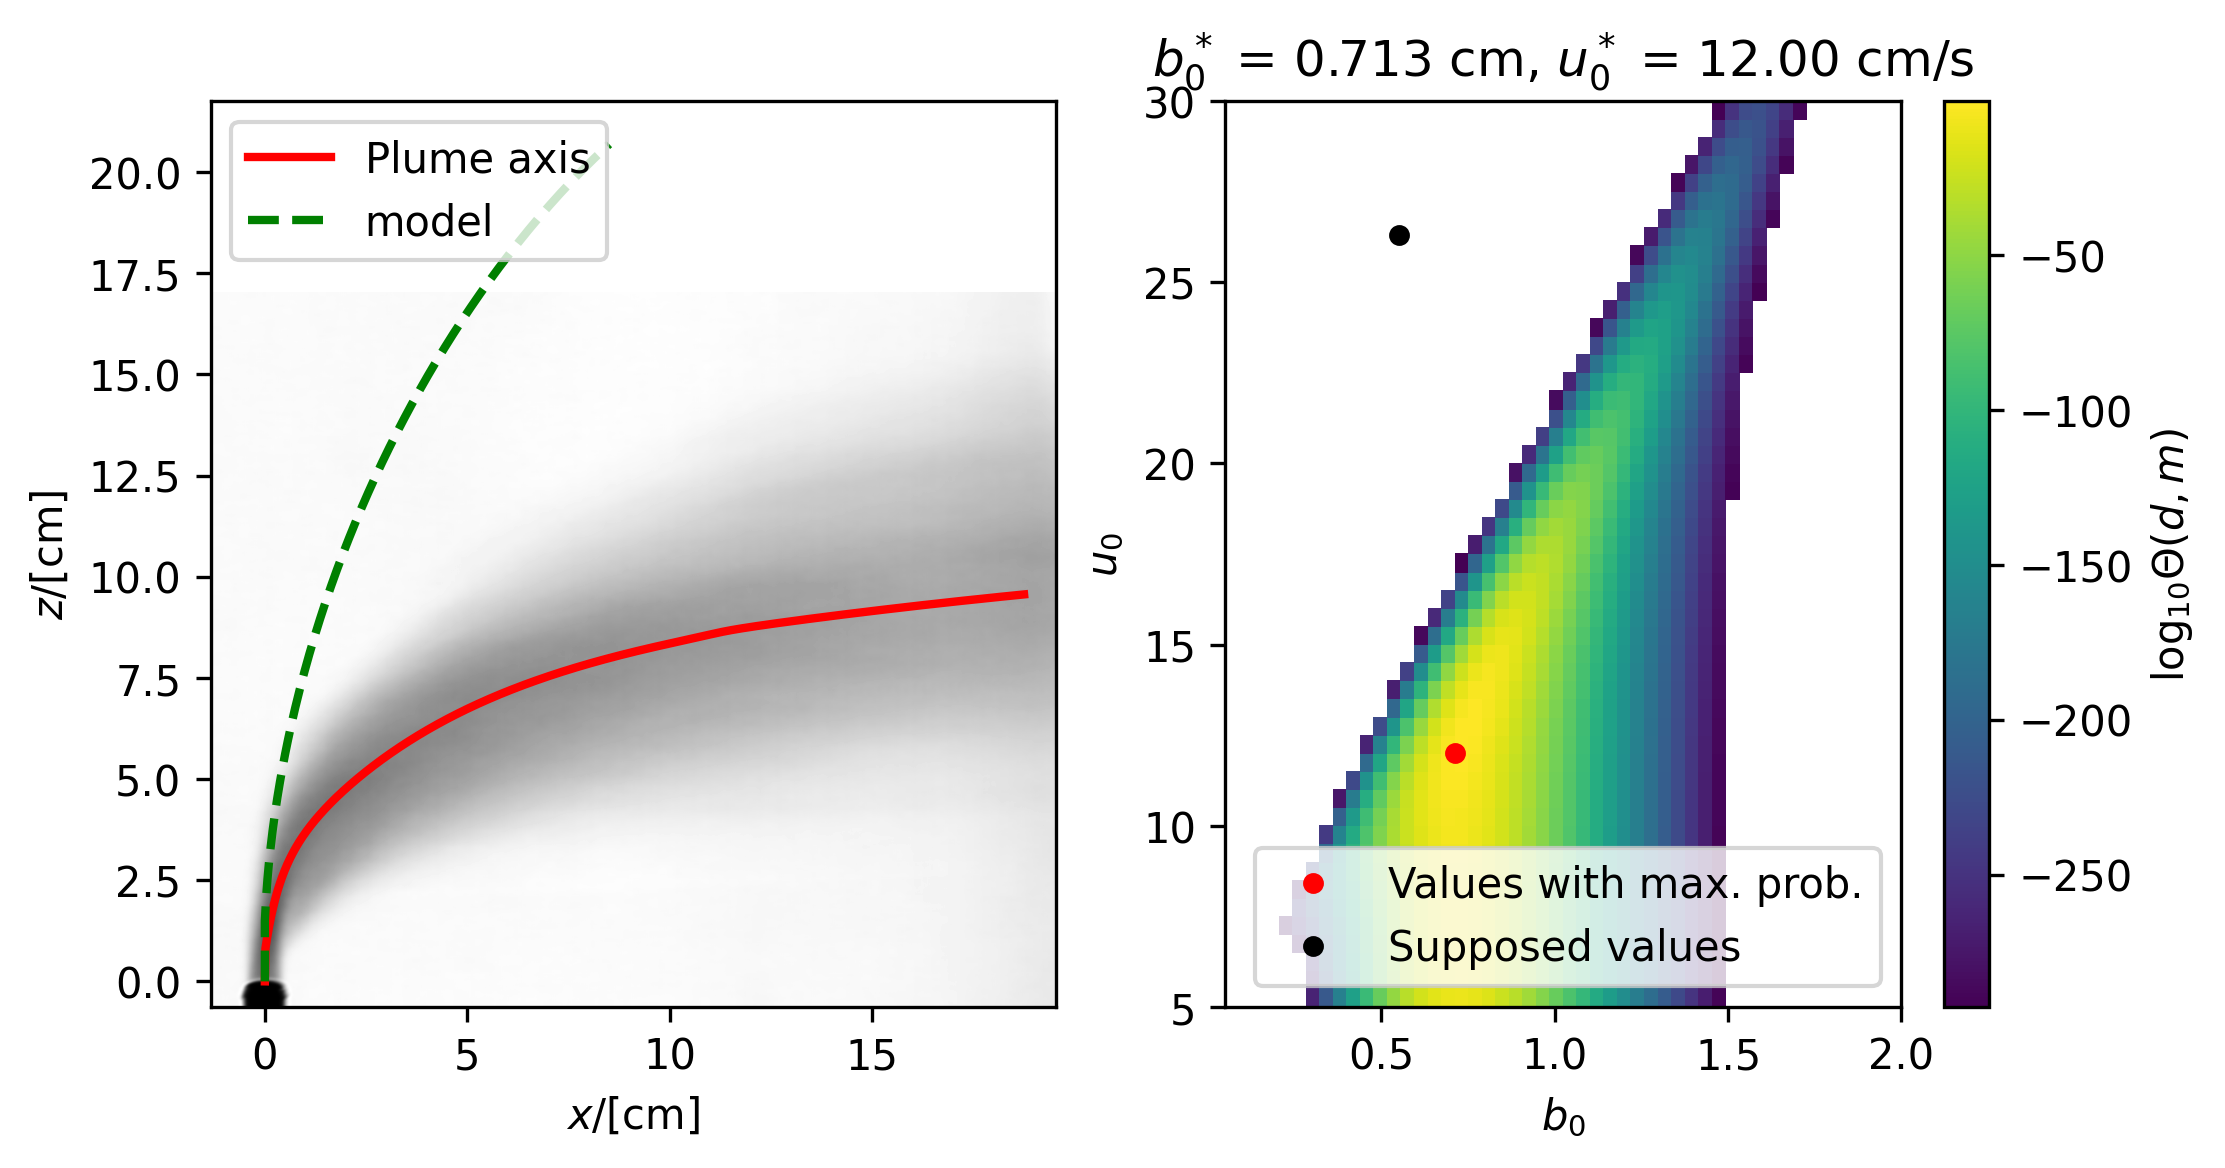

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

### Plot the model solution over the experimental image and data
# Model solution trajectory
xmod, zmod = [0.], [0.]
ds_ = np.diff(sexp)
for (ds, th) in zip(ds_, theta):
    xmod.append(xmod[-1] + ds * np.cos(th))
    zmod.append(zmod[-1] + ds * np.sin(th))
    
# On an image of the experimental plume, show the plume trajectories for
# 1) GCTA, 2) our initial guess, 3) the model solution
ax[0].imshow(data, extent=extent, cmap=plt.cm.gray)
ax[0].invert_yaxis()
ax[0].set_xlabel(r'$x$/[cm]')
ax[0].set_ylabel(r'$z$/[cm]')
# 1) GCTA
ax[0].plot(xexp, zexp, 'r-', label='Plume axis', lw=2)
# 2) our initial guess
# ax[0].plot(exptData.axisLocn_x, exptData.axisLocn_y, 'r--', label='Init. guess', lw=2)
# 3) the model solution
ax[0].plot(xmod, zmod, 'g--', label='model', lw=2)
ax[0].set_xlim((extent[:2]))
ax[0].legend(loc=2)

### Plot optimal values
ui, bi = np.where(objFn == objFn.max())
bOpt = b0Vec[bi[0]]
uOpt = u0Vec[ui[0]]

im = ax[1].pcolor(b0Vec, u0Vec, np.log10(objFn / objFn.sum()))
hX = ax[1].set_xlabel(r'$b_0$')
hY = ax[1].set_ylabel(r'$u_0$')
hL = ax[1].set_title(r'$b^*_0$ = %.3f cm, $u^*_0$ = %.2f cm/s' % 
                     (bOpt, uOpt))

ax[1].plot(bOpt, uOpt, 'r.', ms=8, label='Values with max. prob.')
ax[1].plot(b0theoretical, u0theoretical, 'k.', ms=8, label='Supposed values')

cbar = fig.colorbar(im)
cbar.set_label(r'$\log_{10}{\Theta(d,m)}$')

ax[1].legend(loc=4)
fig.savefig('ProbabilityDistribution_b0u0.png', dpi=300)

(*Left*) Visualisation (logarithmic scale) of the probability density of the parameter space.  (*Right*) Image of experimental plume with calculated and estimated trajectories.  #(*Right*) Difference between experimental (guessed) and model solutions as a function of the distance along the plume axis.  

# To do:
- Identify which cases produce minima in the objective function